# Imports

In [41]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML

#metricas
import sklearn.metrics
import scikitplot        as skplt
from scipy import stats

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle

#modelos
from imblearn.ensemble       import BalancedRandomForestClassifier


## Helper functions

In [42]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
def precision_at_k( data, k=200 ):
    """
    Object that return the precision at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the precision at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=200 ):
    """
    Object that return the recall at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the recall at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def performace(model_name, data, y_val, yhat_class, k=200):
    """

    :param model_name: string, with the name of the algoritm that will be used
    :param data: dataframe sorted by  probabilit given to each iten by the model
    :param y_val: list of the target variable of the dataframe
    :param yhat_class: binary prediction made by the model for each iten
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val, yhat_class,average='macro')
    recal = sklearn.metrics.recall_score(y_val, yhat_class,average='macro')
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_val, yhat_class)
    recal_k = recall_at_k(data, k)
    prec_k = precision_at_k(data, k)

    return pd.DataFrame({'Model Name': model_name,
                         'Precison': prec,
                         'Recall': recal,
                         'Balanced_acc': balanced_acc,
                         'k': k,
                         'Precison at k': prec_k,
                         'Recall at k': recal_k}, index=[0])



In [45]:
def performace_cross_val(data, target, model, model_name, round_n=4, splits=3, shuffle_n=True, random=42, k=200):
    """
    this cross-validation object uses kfold with stratified folds and return the metrics
    :param data: dataframe
    :param target: string, name of the target variable
    :param model: model that will be used
    :param model_name: string with the model name
    :param round_n: int, default=5number of decimal points of the float values that will be returned
    :param splits: int, default=5, number of folds
    :param shuffle_n:bool, default=True, Whether to shuffle each class’s samples before splitting into batches
    :param random: int, default=42 controls the randomness of each fold
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the mean and standard deviation of the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'id'])
    precision = []
    recall = []
    balan_acc = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index].values.ravel())

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:, 1].tolist()

        # sorte by score
        aux = aux.sort_values('score', ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux, k))
        rec_k.append(recall_at_k(aux, k))

    # return a dataset with the metrics
    return pd.DataFrame({'model name': model_name + " CV",
                        'precision_cv': np.round(np.mean(precision), round_n),
                        'prec_std': np.round(np.std(precision), round_n),
                        'recall_cv': np.round(np.mean(recall), round_n),
                        'rec_std': np.round(np.std(recall), round_n),
                        'balanced_acc_cv': np.round(np.mean(balan_acc), round_n),
                        'bal_std': np.round(np.std(balan_acc), round_n),
                        'k': k,
                        'precision_at_k_cv': np.round(np.mean(prec_k), round_n),
                        'perc_k_std': np.round(np.std(prec_k), round_n),
                        'recall_at_k_cv': np.round(np.mean(rec_k), round_n),
                        'rec_k_std': np.round(np.std(rec_k))}, index=[0])




# Load data 

In [46]:
path_local = 'C:/Users/Lavin/Documents/desafios/ifood/'
df6 = pd.read_csv(path_local + 'data/processed/df5.csv')

In [47]:
train = pd.read_csv(path_local + 'src/data/df_train.csv')
val   = pd.read_csv(path_local + 'src/data/df_val.csv')

## Split train and test

In [48]:
X_train = train.copy()
y_train = X_train['response']
X_train = X_train.drop(columns=['id','response'])

In [49]:
x_val = val.copy()
y_val = x_val['response']
x_val = x_val.drop(columns=['id','response'])

# 10.0 Fine tuning

In [50]:
# declarando espaço  dos parametros
param = {"max_depth": [None],
              "max_features": [1, 3,5, 7],
              "min_samples_split": [2, 3,5, 7],
              "min_samples_leaf": [1, 3,5, 7],
              "n_estimators" :[100,300,400,600],
              "criterion": ["gini"]}
# numero de tentativas
MAX_EVAL = 100

**GRID SEARCH**

In [51]:
# import random
# #dataframes para armazenar valores de parametros e resultados
# final_result = pd.DataFrame()
# params_result = pd.DataFrame()

# #loop de treino
# for i in range( MAX_EVAL ):
#    # escolha valores para os parâmetros aleatoriamente
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     aux = pd.DataFrame(hp,index=[i])
#     params_result = pd.concat([params_result,aux])
   
#    # model
#     brf_model = BalancedRandomForestClassifier(n_jobs=-1,random_state=42,warm_start=True,
#                                                max_depth = hp['max_depth'],
#                                                max_features = hp['max_features'],
#                                                min_samples_split = hp['min_samples_split'],
#                                                min_samples_leaf = hp['min_samples_leaf'],
#                                                n_estimators = hp['n_estimators'],
#                                                criterion = hp['criterion'])

#    # performance
#     result = performace_cross_val(df6,'response',brf_model,'balanced rf ' + str(i),k=300)
#     final_result = pd.concat( [final_result, result] )

In [52]:
#final_result.sort_values(by='recall_at_k_cv',ascending=False)

In [53]:
#params_result

# 11 Final model

In [54]:
# parametros escolhidos
final_params = {'max_depth': None,
                 'max_features': 5,
                 'min_samples_split': 2,
                 'min_samples_leaf': 1,
                 'n_estimators': 100,
                 'criterion': 'gini'}

In [55]:
# model
brf_model = BalancedRandomForestClassifier(n_jobs=-1,random_state=42,warm_start=True,
                                               max_depth = final_params['max_depth'],
                                               max_features = final_params['max_features'],
                                               min_samples_split = final_params['min_samples_split'],
                                               min_samples_leaf = final_params['min_samples_leaf'],
                                               n_estimators = final_params['n_estimators'],
                                               criterion = final_params['criterion'])

In [56]:
# treino
brf_model.fit(X_train,y_train.values.ravel())

BalancedRandomForestClassifier(max_features=5, n_jobs=-1, random_state=42,
                               warm_start=True)

In [57]:
#model prediction proba - poder de generalização
yhat_brf_proba = brf_model.predict_proba( x_val )

#model prediction - poder de generalização
yhat_brf_class = brf_model.predict( x_val )

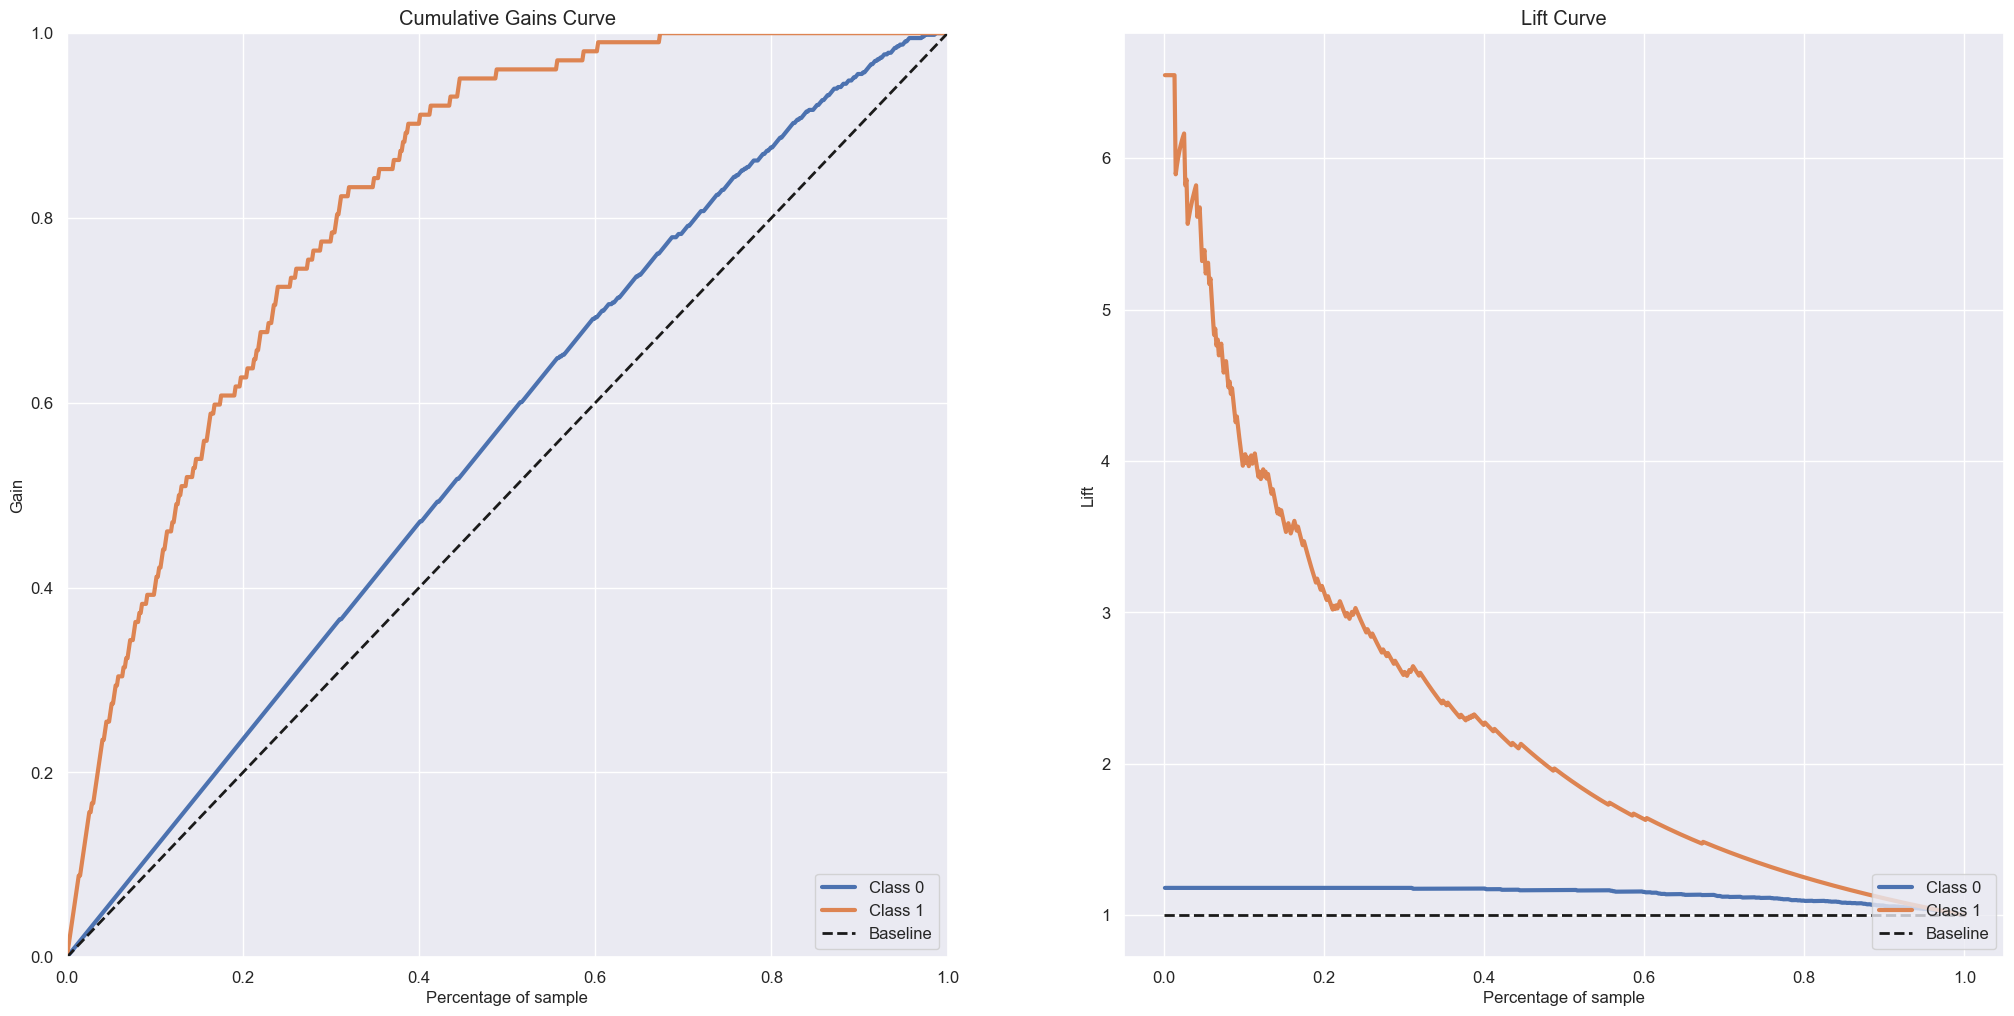

In [58]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_brf_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_brf_proba,ax=ax[1]);

## 11.1  Model performace 

In [59]:
clients = 200

In [60]:
brf_df = val.copy()

In [61]:
brf_df['score_brf'] = yhat_brf_proba[:,1].tolist()
#sort by score

brf_df = brf_df.sort_values('score_brf',ascending=False)

In [62]:
brf_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_brf
561,3584,0.22,0.298362,0.353535,0.791025,0.130653,0.121951,0.065637,0.049618,0.121495,...,0,0,0.732143,1,0.969957,0.318217,0.551984,1,1,0.926667
65,830,0.22,0.449837,0.050505,0.525117,0.241206,0.569106,0.162162,0.671756,0.149533,...,1,1,0.160714,1,0.178827,0.477368,0.655952,2,1,0.920000
156,3725,0.22,0.517437,0.010101,0.835901,0.080402,0.354675,0.166023,0.061069,0.049844,...,1,1,0.625000,1,0.595136,0.548393,0.667857,4,1,0.920000
385,3005,0.22,0.509115,0.070707,0.354990,0.587940,0.689024,0.517375,0.167939,0.457944,...,0,1,0.071429,1,0.084406,0.539649,0.652778,2,1,0.910000
476,3619,0.11,0.532623,0.191919,0.231078,0.125628,0.509146,0.243243,0.526718,0.249221,...,1,0,0.642857,1,0.921316,0.564349,0.455159,1,1,0.910000


In [63]:
brf_performace = performace("balanced random forest",brf_df,y_val,yhat_brf_class,clients)

In [64]:
brf_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,balanced random forest,0.6759,0.788402,0.788402,200,0.39801,0.784314


### 11.1.1 Cross validation

In [73]:
model_final_perf = performace_cross_val(df6,'response',brf_model,'balanced rf ',k=200)

In [74]:
model_final_perf

,model name,precision_cv,prec_std,recall_cv,rec_std,balanced_acc_cv,bal_std,k,precision_at_k_cv,perc_k_std,recall_at_k_cv,rec_k_std
0,balanced rf CV,0.7353,0.0097,0.8765,0.0106,0.8765,0.0106,200,0.4809,0.0102,0.9355,0.0


In [70]:
model_final_perf.to_csv(path_local + 'src/data/model_final_perf.csv',index=False)

# 12.0 save final model 

In [66]:
#pickle.dump(brf_model,open(path_local + 'src/models/brf_final_model.pkl','wb'))